# User to Item Recommendation system

Loading Datasets. 

In [3]:
import pandas as pd
import numpy as np
from keras.models import load_model

links = pd.read_csv('gdrive/My Drive/links.csv')
movies = pd.read_csv('gdrive/My Drive/movies.csv')
ratings = pd.read_csv('gdrive/My Drive/ratings.csv')
tags = pd.read_csv('gdrive/My Drive/tags.csv')

Using TensorFlow backend.


Cleaning genres string. Replacing "|" with " " and replacing null with blank string.

In [0]:
tags_1 = pd.DataFrame(tags.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
df = pd.merge(movies, tags_1,on='movieId', how='left')
df['genres'] = df['genres'].str.replace('|',' ')
df.fillna("",inplace=True)

Label Encoding "movieId" column so that the movieId's start with 1 and end with 9742 (max number of movies in the dataset).



In [0]:
from sklearn.preprocessing import LabelEncoder
item_enc = LabelEncoder()

df['movieId'] = item_enc.fit_transform(df['movieId'].values)

df['movieId'] = df['movieId']+1

Converting upper case characters to lower case. To avoid duplicates when the words are tokenized.

In [0]:
df.genres = df.genres.apply(lambda x: x.lower())
df.tag = df.tag.apply(lambda x: x.lower())

In [0]:
import string
df.genres = df.genres.apply(lambda x: x.translate(string.punctuation))
df.tag = df.tag.apply(lambda x: x.translate(string.digits))

In [0]:
ratings['movieId'] = item_enc.fit_transform(ratings['movieId'].values)

ratings['movieId'] = ratings['movieId']+1


Grouping movies by userId.

In [0]:
user_movies_watched = pd.DataFrame(ratings.groupby(['userId']).apply(lambda x: [list(x['movieId'])]).apply(pd.Series))

Grouping movies by Genres.

In [0]:
genre_classes = pd.DataFrame(df.groupby(['genres']).apply(lambda x: [list(x['movieId'])]).apply(pd.Series)).reset_index()
genre_classes.columns = ['genres','movieId']

Adding a new column which will now represent the unique genre strings.



In [12]:
genre_classes_column = [int(i) for i in range(1,952)]
genre_classes['genres_class'] = np.array(genre_classes_column)
genre_classes

,genres,movieId,genres_class
0,(no genres listed),"[8518, 8685, 8688, 8783, 8837, 8903, 9034, 905...",1
1,action,"[9, 64, 173, 216, 556, 877, 1144, 1202, 1648, ...",2
2,action adventure,"[575, 607, 637, 802, 901, 991, 1209, 1368, 161...",3
3,action adventure animation,"[6926, 7923, 7924, 7925, 7926, 7942, 7943, 795...",4
4,action adventure animation children,"[7902, 7903, 7905, 7907, 8345, 9709]",5
...,...,...,...
946,sci-fi thriller,"[669, 1321, 2599, 2935, 3618, 3671, 3943, 5361...",947
947,sci-fi thriller imax,[7688],948
948,thriller,"[113, 162, 207, 332, 367, 399, 428, 474, 553, ...",949
949,war,"[2006, 2007, 4388, 6787]",950


Adding a new column to the main dataframe, which will now hold the tokenized genres.



In [0]:
genre_classes_column = [int(i) for i in range(1,952)]
genre_classes['genres_class'] = np.array(genre_classes_column)

genre_dict = pd.Series(genre_classes.genres_class.values,index=genre_classes.genres).to_dict()
df_gen = df.genres.values
df_gen=[genre_dict[i] for i in df_gen]
df['genres_class'] = np.array(df_gen)

A dictionary of movies and its unique genre_class. 

In [0]:
genre_movie_dict = pd.Series(df.genres_class.values,index=df.movieId).to_dict()

In [16]:
df.head(3)

,movieId,title,genres,tag,genres_class
0,1,Toy Story (1995),adventure animation children comedy fantasy,pixar pixar fun,352
1,2,Jumanji (1995),adventure children fantasy,fantasy magic board game robin williams game,418
2,3,Grumpier Old Men (1995),comedy romance,moldy old,733


In [17]:
user_movies_watched.head(3)

,0
userId,
1,"[1, 3, 6, 44, 47, 63, 90, 98, 125, 131, 137, 1..."
2,"[278, 292, 1284, 2671, 4608, 5295, 6237, 6299,..."
3,"[31, 462, 546, 566, 586, 657, 697, 832, 853, 9..."


In [0]:
user_movies_watched.columns = ['movies']

Obtaining a single long list which has all the movies seen by every user.
And the same for genres, using the dictionary.

In [0]:
movies_all = user_movies_watched.movies.values
movies_all = [item for sublist in movies_all for item in sublist]
genres_all = [genre_movie_dict[item] for item in movies_all]

In [0]:
# best to have a sequence size of 36: as 100836/36 is divisible

Will be creating a sequence of 36 movies (which will be our movie Input)

In [0]:
maxlen = 36 
step = 36
movies_list = []
genres_list = []
all1 = []
for i in range(0, len(movies_all), step):
    movies_list.append(movies_all[i: i + maxlen])
    genres_list.append(genres_all[i: i + maxlen])
    

In [21]:
len(movies_list)

2801

In [22]:
gen_size = max(genres_all)
movies_size = max(movies_all)

print(gen_size,movies_size)

951 9724


Scaling movies array.

In [0]:
x_mov = np.asarray(movies_list).astype('float32')/9724
x_gen = np.asarray(genres_list)

One hot encoded outputs corresponding the movie inputs.



In [0]:
y = np.zeros((2801, 9743))
def y_s(j,row):
    for i in row:
        y[j,i]=1

for i in range(0,2801):
    y_s(i,movies_list[i])

In [28]:
y

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Custom accuracy metric to assess multi label performance.

In [0]:
from keras import backend as K

def full_multi_label_metric(y_true, y_pred):
    comp = K.equal(y_true, K.round(y_pred))
    return K.cast(K.all(comp, axis=-1), K.floatx())

The model.

In [0]:
import keras
from keras.layers import Concatenate, Dense, Dropout, Flatten, LSTM
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda
from keras.layers import Bidirectional

def rec():
    
    
  
    genres = Input(shape=(36,))
    g = Embedding(gen_size+1, 50)(genres)
    g = Flatten()(g)

    movies = Input(shape=(36,))
    
    x = Concatenate()([movies, g])
    x = Reshape((1,1836))(x)
    x = LSTM(100) (x)
    x = Activation('relu')(x)
    x = Dense(9743)(x)
    x = Activation('sigmoid')(x)
    
    model = Model(inputs=[movies, genres], outputs=x)
    opt = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt,metrics=[full_multi_label_metric])
    return model


In [131]:

model = rec()
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 36)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 36, 50)       47600       input_15[0][0]                   
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 36)           0                                            
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 1800)         0           embedding_8[0][0]                
____________________________________________________________________________________________

In [ ]:
history = model.fit(x=[x_mov,x_gen], y=y, batch_size=16, epochs=100, verbose=2)

loss and accuracy plots.

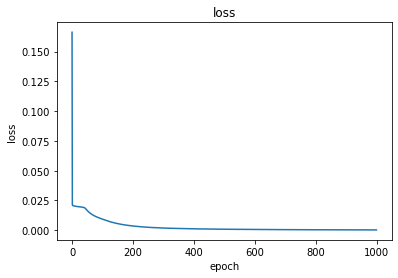

In [90]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

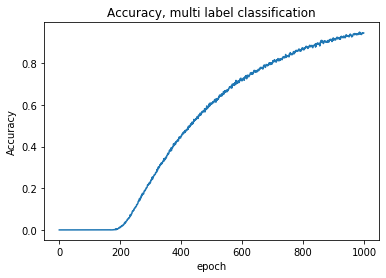

In [91]:
import matplotlib.pyplot as plt
plt.plot(history.history['full_multi_label_metric'])
plt.title('Accuracy, multi label classification')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.show()

To prepare custom inputs which will be fed to our model.



In [0]:
def prepare_inputs(movie_input):
    """
    With only MovieID's as the input to our model, we are required to 
    obtain the required genre's and tag's and bring our raw input to
    the required shape.
    """
    
    movie_input = [DF.movieId[DF['title']==i].iloc[0] for i in movie_input]
    movies_copy = movie_input[:]

    genres = (DF.genres_class[DF["movieId"].isin(movie_input)].values).tolist()

    genres = pad(genres, INPUT_LENGTH["genre_len"])    
    movie_input = pad(movie_input, INPUT_LENGTH["movie_len"])
    
    return movie_input, genres, movies_copy


predict

In [0]:
#p = model.predict([np.array([movie_input,]),np.array([g_input,])])
p = model.predict([np.array([movie_input,]),np.array([g_input,])])

Results.

In [187]:
def result(movie_copy, most_similar):
    """
    From the prediction indices, the corresponding movies are extracted 
    from the dataset.
    Also the original "watched" movie information is obtained.
    We return two dataframes: Watched and the Recommendations.
    """

    rec_movies = DF.set_index("movieId").loc[most_similar].reset_index()
    rec_movies = rec_movies.iloc[:,:-1]
    rec_movies = rec_movies[~rec_movies["movieId"].isin(movie_copy)]
    watched_movies = DF.set_index("movieId").loc[movie_copy].reset_index()
    watched_movies = watched_movies.iloc[:,1:]
    return watched_movies, rec_movies


,movieId,Title,Genres,Tags,genres_class
0,258,Pulp Fiction (1994),comedy crime drama thriller,good dialogue great soundtrack non-linear cult...,649
1,99,Taxi Driver (1976),crime drama thriller,assassination,774
2,419,Jurassic Park (1993),action adventure sci-fi thriller,dinosaur,130
3,2084,"Yards, The (2000)",crime drama,,748
4,250,Natural Born Killers (1994),action crime thriller,brutality controversial dark comedy psychedeli...,261
5,303,Ace Ventura: Pet Detective (1994),comedy,,635
6,278,"Shawshank Redemption, The (1994)",crime drama,prison stephen king wrongful imprisonment morg...,748
7,521,Fargo (1996),comedy crime drama thriller,based on a true story dark comedy kidnapping s...,649
8,312,"Crow, The (1994)",action crime fantasy thriller,,245
9,487,True Romance (1993),crime thriller,,796
